# Network intrusion detection
The data used here is the original version of KDD Cup 99 data
- https://kdd.ics.uci.edu/databases/kddcup99/
## Load data

In [1]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
columns = ['duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'label']

In [4]:
train = pd.read_csv('kddcup.data.gz', header=None, names=columns)
test = pd.read_csv('corrected.gz', header=None, names=columns)

In [5]:
print(train.shape, test.shape)

(4898431, 42) (311029, 42)


In [6]:
pd.set_option('display.max_columns', 0)
train.head(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,normal.


## Visualization

In [7]:
train.label.value_counts()

smurf.              2807886
neptune.            1072017
normal.              972781
satan.                15892
ipsweep.              12481
portsweep.            10413
nmap.                  2316
back.                  2203
warezclient.           1020
teardrop.               979
pod.                    264
guess_passwd.            53
buffer_overflow.         30
land.                    21
warezmaster.             20
imap.                    12
rootkit.                 10
loadmodule.               9
ftp_write.                8
multihop.                 7
phf.                      4
perl.                     3
spy.                      2
Name: label, dtype: int64

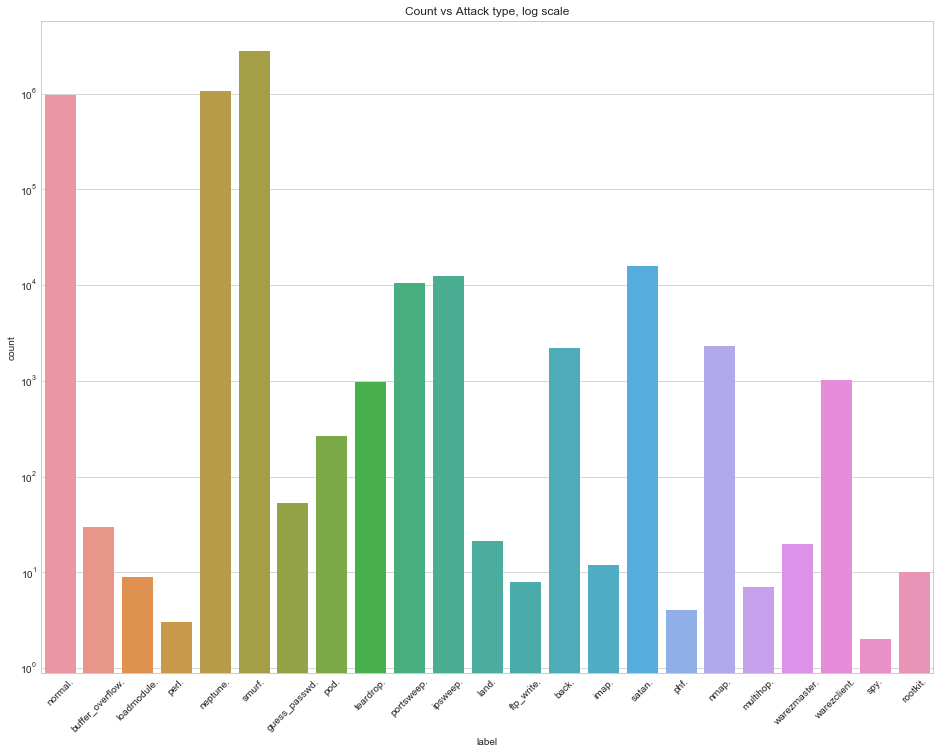

In [8]:
# Plot Count vs attack type in log scale

plt.figure(figsize=(16, 12))
sns.set_style('whitegrid')
plt.xticks(rotation=45)
sns.countplot('label', data=train, log=True)
plt.title('Count vs Attack type, log scale')
plt.savefig('figures/fig_1.png')

In [9]:
# exclude category features and labels

temp = train.drop(['protocol_type', 'service', 'flag', 'label'], axis=1)

C:\Anaconda2\envs\py36\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Anaconda2\envs\py36\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


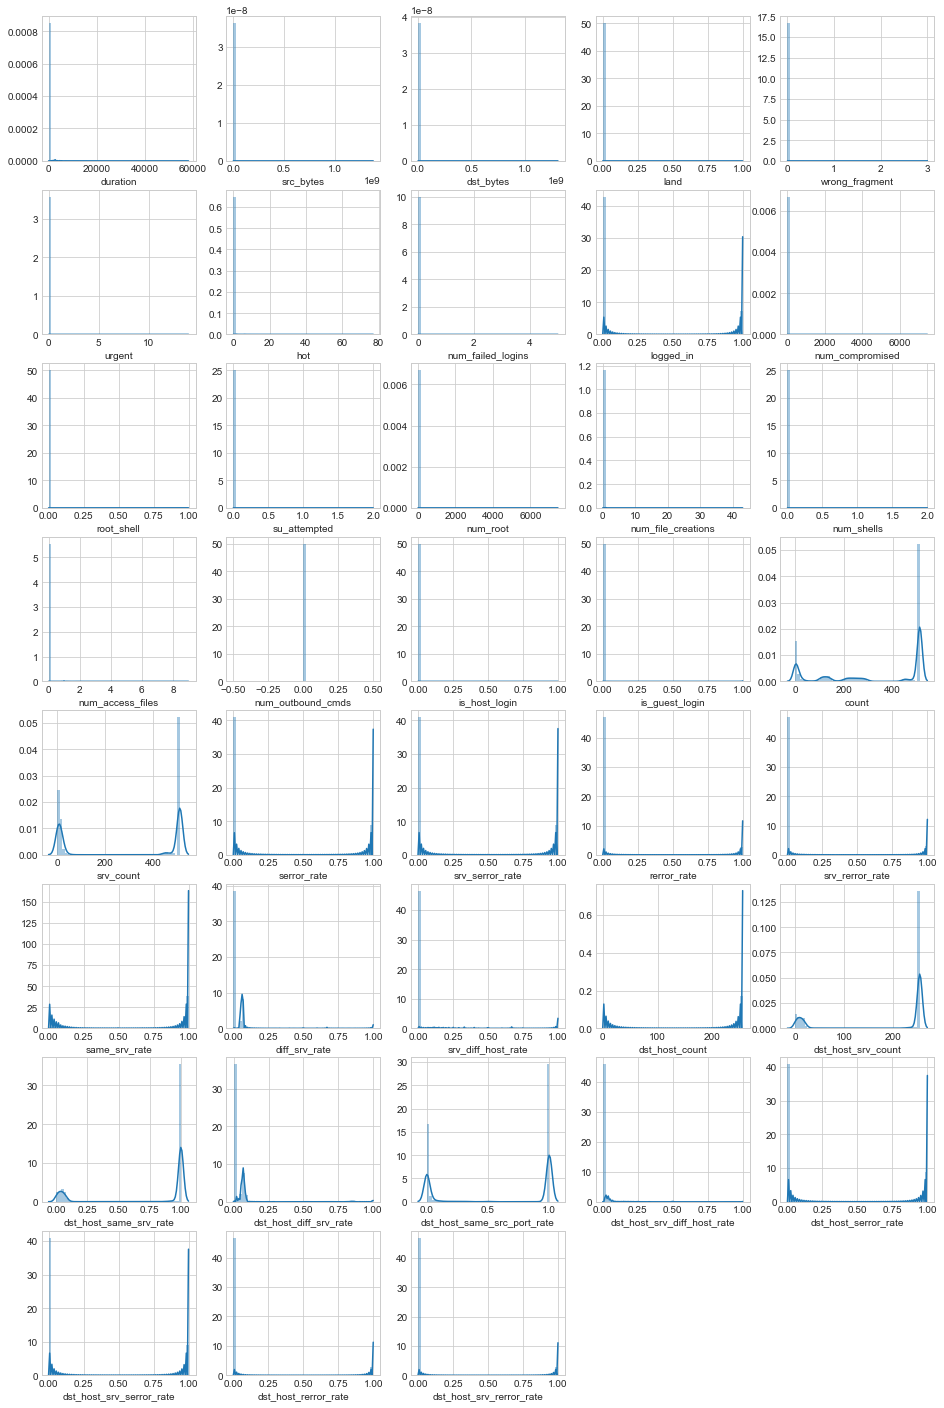

In [10]:
# plot numerical features distribution

fig = plt.figure(figsize=(16, 25))
for k, v in enumerate(list(temp.columns)):
    ax = fig.add_subplot(8, 5, 1+k)
    sns.distplot(temp[v], ax=ax)
fig.savefig('figures/fig_2.png')

In [11]:
# Label encoding category features

from sklearn import preprocessing
temp_cat = train[['protocol_type', 'service', 'flag']].apply(preprocessing.LabelEncoder().fit_transform)

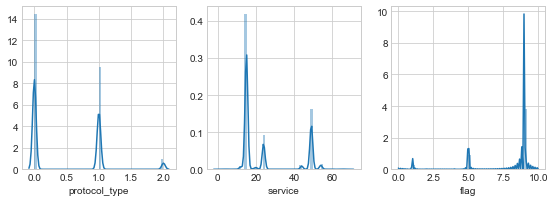

In [12]:
# plot category features distribution

fig = plt.figure(figsize=(16, 3))
for k, v in enumerate(list(temp_cat.columns)):
    ax = fig.add_subplot(1, 5, 1+k)
    sns.distplot(temp_cat[v], ax=ax)
fig.savefig('figures/fig_3.png')

## Data preprocessing

In [13]:
# https://www.researchgate.net/publication/267558979_Efficient_Classifier_for_R2L_and_U2R_Attacks
# https://ll.mit.edu/ideval/docs/attackDB.html

attack_category = {
                   'normal': ['normal'],
                   'probe': ['satan', 'mscan', 'portsweep', 'saint', 'ipsweep', 'nmap'],
                   'dos': ['smurf', 'neptune', 'mailbomb', 'back', 'apache2', 'processtable', 'pod', 'teardrop', 'land', 
                           'udpstorm'],
                   'u2r': ['buffer_overflow', 'ps', 'rootkit', 'xterm', 'sqlattack', 'loadmodule', 'perl'],
                   'r2l': ['snmpgetattack', 'guess_passwd', 'snmpguess', 'warezmaster', 'httptunnel', 'multihop', 'named', 
                           'sendmail', 'xlock', 'xsnoop', 'ftp_write', 'worm', 'phf', 'imap', 'warezclient', 'spy']
                   }

In [14]:
# transform attack type to 1 of 4 attack categories: probe, denial_of_service, user_to_root, remote_to_local

def type_category(label):
    for k, v in attack_category.items():
        if label in v:
            return k

In [15]:
# some features are skewed here, should take log before scaling

train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4898431.0,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06
mean,4.834243e+01,1.834621e+03,1.093623e+03,5.716116e-06,6.487792e-04,7.961733e-06,1.243766e-02,3.205108e-05,1.435290e-01,8.088304e-03,6.818510e-05,3.674646e-05,1.293496e-02,1.188748e-03,7.430951e-05,1.021143e-03,0.0,4.082940e-07,8.351654e-04,3.349734e+02,2.952671e+02,1.779703e-01,1.780370e-01,5.766509e-02,5.773010e-02,7.898842e-01,2.117961e-02,2.826080e-02,2.329811e+02,1.892142e+02,7.537132e-01,3.071111e-02,6.050520e-01,6.464107e-03,1.780911e-01,1.778859e-01,5.792780e-02,5.765941e-02
std,7.233298e+02,9.414311e+05,6.450123e+05,2.390833e-03,4.285434e-02,7.215084e-03,4.689782e-01,7.299408e-03,3.506116e-01,3.856481e+00,8.257146e-03,8.082432e-03,3.938075e+00,1.241857e-01,8.737590e-03,3.551048e-02,0.0,6.389788e-04,2.888716e-02,2.119908e+02,2.459927e+02,3.818756e-01,3.822541e-01,2.322529e-01,2.326604e-01,3.892958e-01,8.271458e-02,1.405596e-01,6.402094e+01,1.059128e+02,4.111860e-01,1.085432e-01,4.809877e-01,4.125978e-02,3.818382e-01,3.821774e-01,2.309428e-01,2.309777e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,4.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1.210000e+02,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.550000e+02,4.900000e+01,4.100000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,5.200000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,5.100000e+02,5.100000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.550000e+02,2.550000e+02,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,1.032000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,5.110000e+02,5.110000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.550000e+02,2.550000e+02,1.000000e+00,4.000000e-02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.

In [16]:
def preprocess(df):
    
    # exclude unuseful features and label
    X = df.drop(['num_outbound_cmds', 'label'], axis=1)
    
    # take log on skewed features
    skewed_features = ['duration', 'src_bytes', 'dst_bytes', 'num_compromised', 'num_root', 'count', 'srv_count', 
                       'dst_host_count', 'dst_host_srv_count', 'urgent', 'hot', 'num_file_creations']    
    X[skewed_features] = X[skewed_features].apply(lambda x: np.log(x + 1))
    
    # get dummy for category features
    X = pd.get_dummies(X, columns=['protocol_type', 'service', 'flag'])
        
    # map label/attack type to category
    y = df.label.apply(lambda l: l.strip('.')).apply(type_category)
    
    return X, y

In [17]:
X, y = preprocess(train)
print(X.shape, y.shape)

(4898431, 121) (4898431,)


In [18]:
X.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
count,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06
mean,1.030485e-01,4.953666e+00,1.149355e+00,5.716116e-06,6.487792e-04,3.372279e-06,2.849233e-03,3.205108e-05,1.435290e-01,5.634593e-04,6.818510e-05,3.674646e-05,1.778947e-03,4.448850e-04,7.430951e-05,1.021143e-03,4.082940e-07,8.351654e-04,5.047960e+00,4.449179e+00,1.779703e-01,1.780370e-01,5.766509e-02,5.773010e-02,7.898842e-01,2.117961e-02,2.826080e-02,5.315695e+00,4.688051e+00,7.537132e-01,3.071111e-02,6.050520e-01,6.464107e-03,1.780911e-01,1.778859e-01,5.792780e-02,5.765941e-02,5.784597e-01,3.818770e-01,3.966331e-02,1.063606e-04,2.755985e-05,2.200705e-04,4.082940e-07,6.904252e-04,2.137419e-04,2.084341e-04,2.145585e-04,2.180290e-04,2.155792e-04,2.161917e-04,2.272156e

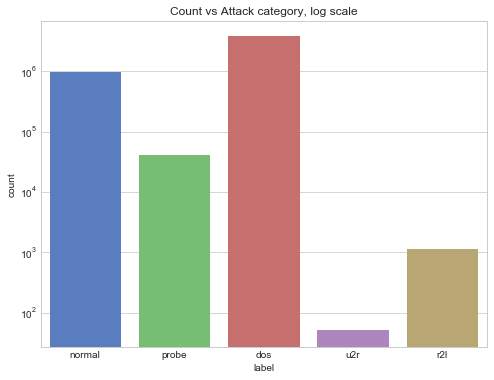

In [19]:
# Plot Count vs attack category in log scale

plt.figure(figsize=(8, 6))
sns.set_style('whitegrid')
#plt.xticks(rotation=45)
sns.countplot('label', data=pd.Series({'label':y}), log=True, order=['normal', 'probe', 'dos', 'u2r', 'r2l'], palette='muted')
plt.title('Count vs Attack category, log scale')
plt.savefig('figures/fig_4.png')

## Data scaling

In [20]:
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [21]:
pd.DataFrame(data=X_scaled, columns=X.columns).describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
count,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06
mean,9.390347e-03,2.353809e-01,5.474879e-02,5.716116e-06,2.162597e-04,1.245279e-06,6.539875e-04,6.410216e-06,1.435290e-01,6.316816e-05,6.818510e-05,1.837323e-05,1.994667e-04,1.175641e-04,3.715475e-05,1.134604e-04,4.082940e-07,8.351654e-04,8.091851e-01,7.132010e-01,1.779703e-01,1.780370e-01,5.766509e-02,5.773010e-02,7.898842e-01,2.117961e-02,2.826080e-02,9.586159e-01,8.454285e-01,7.537132e-01,3.071111e-02,6.050520e-01,6.464107e-03,1.780911e-01,1.778859e-01,5.792780e-02,5.765941e-02,5.784597e-01,3.818770e-01,3.966331e-02,1.063606e-04,2.755985e-05,2.200705e-04,4.082940e-07,6.904252e-04,2.137419e-04,2.084341e-04,2.145585e-04,2.180290e-04,2.155792e-04,2.161917e-04,2.272156e

## PCA for visualization

In [22]:
from sklearn.decomposition import PCA

### 2D plot

In [23]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [24]:
# print cumulated explained_variance_ratio

def print_var(pca):
    print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

In [25]:
print_var(pca)

[ 59.18  79.09]


In [26]:
pca_2d = pd.DataFrame(data=X_pca, columns=['PCA_1', 'PCA_2']).join(y)
pca_2d.head()

,PCA_1,PCA_2,label
0,0.907787,1.795519,normal
1,0.302416,1.637560,normal
2,0.457217,1.773180,normal
3,0.482151,1.780854,normal
4,0.485863,1.765850,normal


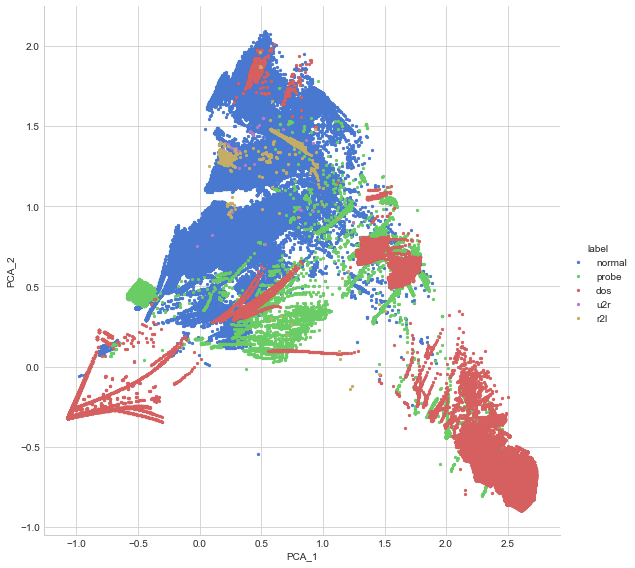

In [27]:
sns.set_style('whitegrid')
fig = sns.FacetGrid(data=pca_2d, hue='label', aspect=1, size=8, hue_order=['normal', 'probe', 'dos', 'u2r', 'r2l'], 
                    legend_out=True, palette='muted')
fig.map(plt.scatter, 'PCA_1', 'PCA_2', s=5).add_legend()
fig.savefig('figures/fig_5.png')

### 3D plot

In [28]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

In [29]:
print_var(pca)

[ 59.18  79.09  89.2 ]


In [30]:
pca_3d = pd.DataFrame(data=X_pca, columns=['PCA_1', 'PCA_2', 'PCA_3']).join(y)
pca_3d.head()

,PCA_1,PCA_2,PCA_3,label
0,0.907787,1.795519,-0.403222,normal
1,0.302416,1.637560,-0.486372,normal
2,0.457217,1.773180,-0.518546,normal
3,0.482151,1.780854,-0.527152,normal
4,0.485863,1.765850,-0.524891,normal


In [31]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

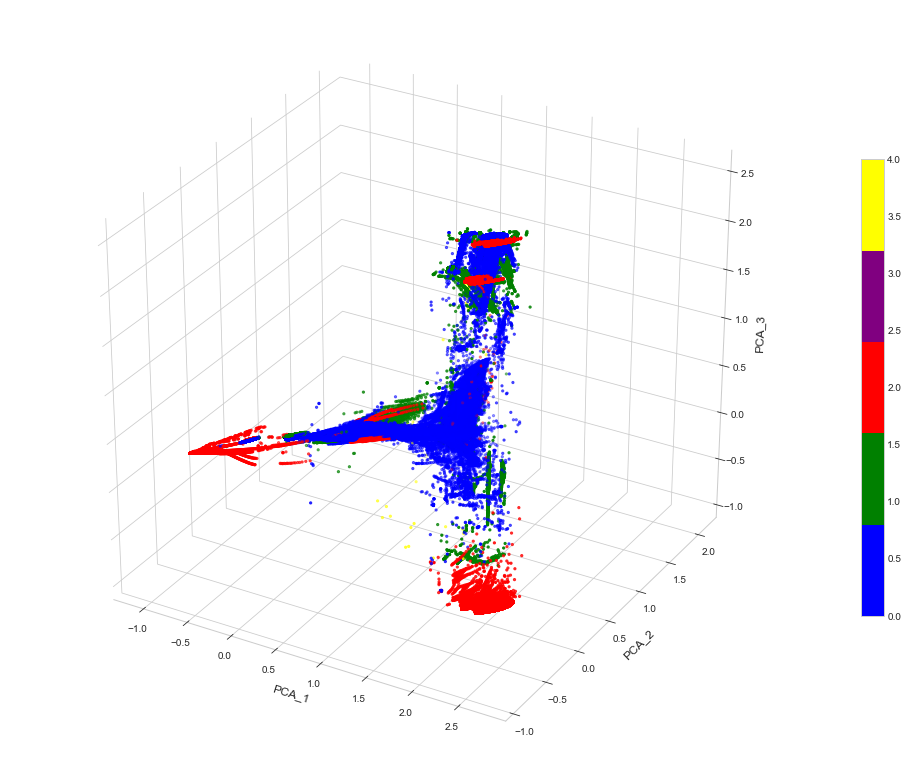

In [32]:
fig = plt.figure(figsize=(18, 14))
ax = fig.add_subplot(111, projection='3d')
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.set_xlabel('PCA_1', fontsize = 12)
ax.set_ylabel('PCA_2', fontsize = 12)
ax.set_zlabel('PCA_3', fontsize = 12)

color = pca_3d.label.map({'normal':0.0, 'probe':1.0, 'dos':2.0, 'u2r':3.0, 'r2l':4.0})

# Display order: Normal, Probe, Dos, U2R, R2L
my_colors = ["#0000ff", "#008000", "#ff0000", "#800080", "#ffff00"]
my_cmap = ListedColormap(sns.color_palette(my_colors).as_hex())

p = ax.scatter(pca_3d.PCA_1, pca_3d.PCA_2, pca_3d.PCA_3, marker='o', s=5, c=color, cmap=my_cmap)
fig.colorbar(p, shrink=0.6)
fig.savefig('figures/fig_6.png')

## Modeling

In [33]:
X_test, y_test = preprocess(test)

In [34]:
print(X.shape, y.shape, X_test.shape, y_test.shape)

(4898431, 121) (4898431,) (311029, 116) (311029,)


In [35]:
print(train.service.nunique(), test.service.nunique())

70 65


In [36]:
X_test = X_test.T.reindex(X.columns).T.fillna(0)

In [37]:
print(X.shape, X_test.shape)

(4898431, 121) (311029, 121)


In [38]:
X_test_scaled = scaler.transform(X_test)

In [39]:
category_label = {'normal':0, 'probe':1, 'dos':2, 'u2r':3, 'r2l':4}

y = y.map(category_label).astype('int')
y_test = y_test.map(category_label).astype('int')

### PCA for feature reduction

In [40]:
pca = PCA(n_components=10)
X_reduced = pca.fit_transform(X_scaled)

In [41]:
print_var(pca)

[ 59.18  79.09  89.2   92.71  94.21  95.44  96.4   97.03  97.43  97.79]


In [42]:
X_test_reduced = pca.transform(X_test_scaled)

In [43]:
print(X_reduced.shape, X_test_reduced.shape)

(4898431, 10) (311029, 10)


### MLP

In [44]:
from keras.utils import to_categorical

# one-hot encode the labels
num_classes = y.nunique()
y_cat = to_categorical(y, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

Using TensorFlow backend.


In [45]:
# break training set into training and validation sets
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(X_reduced, y_cat, test_size=0.2, random_state=1)

# print number of training, validation, and test samples
print(x_train.shape[0], 'Train samples')
print(x_valid.shape[0], 'Validation samples')
print(X_test_reduced.shape[0], 'Test samples')

3918744 Train samples
979687 Validation samples
311029 Test samples


In [61]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

# define the model
model = Sequential()

model.add(Dense(200, input_dim=10, use_bias=True, activation='relu'))
#model.add(Dropout(0.1))
#model.add(Dense(128, use_bias=True, activation='relu'))
#model.add(Dropout(0.1))
#model.add(Dense(32, use_bias=True, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(num_classes, use_bias=True, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 200)               2200      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 1005      
Total params: 3,205
Trainable params: 3,205
Non-trainable params: 0
_________________________________________________________________


In [62]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [63]:
from keras.callbacks import ModelCheckpoint  
import h5py

# train the model
checkpointer = ModelCheckpoint(filepath='MLPKDD.weights.best.hdf5', verbose=1, save_best_only=True)
model.fit(x_train, y_train, epochs=25, validation_data=(x_valid, y_valid), callbacks=[checkpointer], verbose=2, shuffle=True)

Train on 3918744 samples, validate on 979687 samples
Epoch 1/25
Epoch 00000: val_loss improved from inf to 0.00244, saving model to MLPKDD.weights.best.hdf5
107s - loss: 0.0044 - acc: 0.9990 - val_loss: 0.0024 - val_acc: 0.9992
Epoch 2/25
Epoch 00001: val_loss improved from 0.00244 to 0.00181, saving model to MLPKDD.weights.best.hdf5
109s - loss: 0.0023 - acc: 0.9994 - val_loss: 0.0018 - val_acc: 0.9996
Epoch 3/25
Epoch 00002: val_loss improved from 0.00181 to 0.00173, saving model to MLPKDD.weights.best.hdf5
113s - loss: 0.0017 - acc: 0.9996 - val_loss: 0.0017 - val_acc: 0.9996
Epoch 4/25
Epoch 00003: val_loss improved from 0.00173 to 0.00139, saving model to MLPKDD.weights.best.hdf5
111s - loss: 0.0016 - acc: 0.9997 - val_loss: 0.0014 - val_acc: 0.9997
Epoch 5/25
Epoch 00004: val_loss did not improve
110s - loss: 0.0015 - acc: 0.9997 - val_loss: 0.0014 - val_acc: 0.9997
Epoch 6/25
Epoch 00005: val_loss did not improve
110s - loss: 0.0015 - acc: 0.9997 - val_loss: 0.0015 - val_acc: 0.

In [64]:
# load the weights that yielded the best validation accuracy
model.load_weights('MLPKDD.weights.best.hdf5')

In [65]:
# evaluate and print test accuracy
score = model.evaluate(X_test_reduced, y_test_cat, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.937976844604


In [66]:
preds = model.predict_classes(X_test_reduced, verbose=0)

In [67]:
from pandas_ml import ConfusionMatrix

cm = ConfusionMatrix(y_test, preds)
cm

Predicted      0     1       2  3     4  __all__
Actual                                          
0          60294   253      43  0     3    60593
1            512  3462     190  0     2     4166
2           5864    63  223926  0     0   229853
3             67     0       0  1     2       70
4          12240    48       2  2  4055    16347
__all__    78977  3826  224161  3  4062   311029

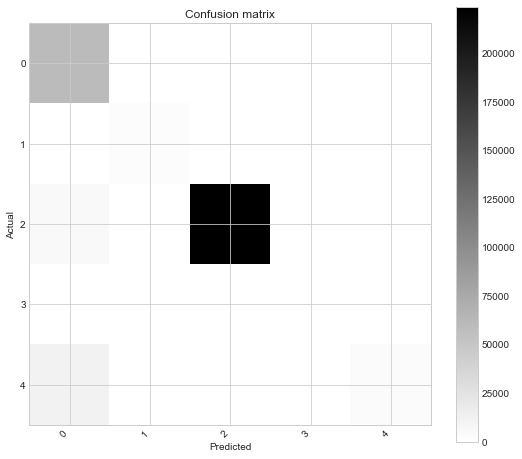

In [68]:
cm.plot()

In [69]:
cm.classification_report

,precision,recall,F1_score,support
Classes,,,,
0,0.763437,0.995065,0.863997,60593
1,0.904861,0.831013,0.866366,4166
2,0.998952,0.974214,0.986428,229853
3,0.333333,0.0142857,0.0273973,70
4,0.998277,0.248058,0.397374,16347
__avg / total__,0.951624,0.937977,0.929793,311029


### KNN

In [70]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [71]:
pca = PCA(n_components=4)
X_knn = pca.fit_transform(X_scaled)

In [72]:
print_var(pca)

[ 59.18  79.09  89.2   92.71]


In [73]:
X_test_knn = pca.transform(X_test_scaled)

In [74]:
print(X_knn.shape, X_test_knn.shape)

(4898431, 4) (311029, 4)


In [77]:
def knn_test(K):
    for k in K:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_knn, y)
        preds_knn = knn.predict(X_test_knn)
        score = accuracy_score(y_test, preds_knn)
        cm_knn = ConfusionMatrix(y_test, preds_knn)
        print('K =', k, 'Accuracy =', score)
        print(cm_knn)
        print(cm_knn.classification_report)

knn_test(range(1, 6, 1))

K = 1 Accuracy = 0.917338897659
Predicted      0     1       2   3    4  __all__
Actual                                          
0          59641   277     672   1    2    60593
1            553  3428     179   0    6     4166
2           6579   761  222193  14  306   229853
3             63     0       0   3    4       70
4          16074   176       0  43   54    16347
__all__    82910  4642  223044  61  372   311029
                 precision      recall    F1_score support
Classes                                                   
0                 0.719346    0.984289    0.831216   60593
1                 0.738475    0.822852    0.778383    4166
2                 0.996185    0.966674    0.981208  229853
3                0.0491803   0.0428571   0.0458015      70
4                 0.145161  0.00330336  0.00645972   16347
__avg / total__    0.89386    0.917339    0.897829  311029
K = 2 Accuracy = 0.917017384231
Predicted      0     1       2   3   4  __all__
Actual                  

### Dummy classifier

In [55]:
from sklearn.dummy import DummyClassifier

In [56]:
dummy = DummyClassifier(random_state=1)

In [57]:
dummy.fit(X, y)

DummyClassifier(constant=None, random_state=1, strategy='stratified')

In [58]:
dummy.score(X_test, y_test)

0.62580659681251583

In [59]:
preds_dummy = dummy.predict(X_test)
cm = ConfusionMatrix(y_test, preds_dummy)
cm

Predicted      0     1       2   3   4  __all__
Actual                                         
0          12019   524   48037   2  11    60593
1            806    35    3323   0   2     4166
2          45196  2013  182586   8  50   229853
3             16     0      54   0   0       70
4           3235   137   12971   0   4    16347
__all__    61272  2709  246971  10  67   311029

In [60]:
cm.classification_report

,precision,recall,F1_score,support
Classes,,,,
0,0.196158,0.198356,0.197251,60593
1,0.0129199,0.00840134,0.0101818,4166
2,0.739301,0.79436,0.765842,229853
3,0,0,0,70
4,0.0597015,0.000244693,0.000487389,16347
__avg / total__,0.587875,0.625807,0.604553,311029


## Appendix

In [75]:
train_labels = pd.DataFrame(train.label.apply(lambda l: l.strip('.')).apply(type_category))
test_labels = pd.DataFrame(test.label.apply(lambda l: l.strip('.')).apply(type_category))

order = ['normal', 'probe', 'dos', 'u2r', 'r2l']

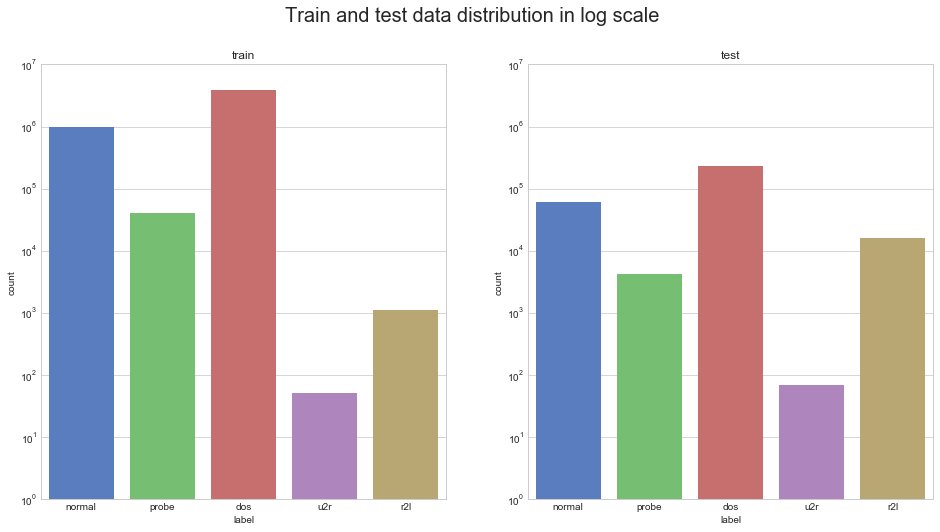

In [76]:
fig = plt.figure(figsize=(16,8))
fig.suptitle('Train and test data distribution in log scale', fontsize=20)

ax1 = fig.add_subplot(121)
ax1.set_title('train')
ax1.set_ylim([1,10**7])
sns.countplot(x='label', data=train_labels, order=order, ax=ax1, palette='muted', log=True)

ax2 = fig.add_subplot(122)
ax2.set_title('test')
ax2.set_ylim([1,10**7])
sns.countplot(x='label', data=test_labels, order=order, ax=ax2, palette='muted', log=True)

fig.savefig('figures/fig_7.png')